# Simple regression example

In this notebook, we will explore the housing dataset (house prices in California (years ago)). We aim to explore tabular data and develop a simple model to predict house prices given house features.

## 1. Download and explore Input Data

Let's start downloading and loading the input data.

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

/tmp/ipykernel_12543/1019307042.py:14: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tarball.extractall(path="datasets")


Now, in the datasets folder, we have the housing dataset: `datasets/housing/housing.csv.` Let's explore it to better understand the input data.

The method below shows the first five samples of our dataset. `housing.head()` will show the last five samples. We can also specify the number of samples we want to see (e.g., `housing.head(10)`)

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


We can also explore our data's attributes, visualize column names, determine if missing values exist, and verify the data type.

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


The output above shows that the `total_bedrooms` column has missing data (Our dataset has 20640 lines, but the column `total-bedrooms` has only 20433 non-null data.

Also, the column `ocean_proximity` has non-numeric data (`object`). It is important to understand this column and convert it to numeric data. Ultimately, data fed to machine learning models, classical or deep-learning approaches, must always be numeric!

In [4]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

We can also show some statistics of our data, to get additional insights:

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


From the output above, we can see that columns have different scales. So, it is valuable to normalize input data before using it to train a model.

The columns mean:

1. **Longitude:** Geographic coordinate that specifies east-west position. Negative values indicate western hemisphere locations (typical for California).
2. **Latitude:** Geographic coordinate that specifies north-south position. Together with longitude, it pinpoints the exact location of each district.
3. **housing_median_age:** Median age of houses in the district. Lower values indicate recently built houses.
4. **total_rooms:** Total number of rooms in all homes in the district.
total_bedrooms: Total number of bedrooms in all homes in the district. Note that this column has 20,433 non-null values, meaning there are 207 missing values.
5. **Population:** Total number of people living in the district.
6. **Households:** Number of households --- groups of people living in one home --- in the district.
7. **median_income:** Median income of households in the district (likely in tens of thousands of dollars).
8. **median_house_value:** Median value of homes in the district (likely in dollars). The target variable for prediction in housing price models.
9. ocean_proximity: Categorical variable indicating the district's proximity to the ocean. The 'object' data type suggests this is stored as text (e.g., "near bay," "inland," "<1H OCEAN").

Let us then explore the distribution of our data.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sn

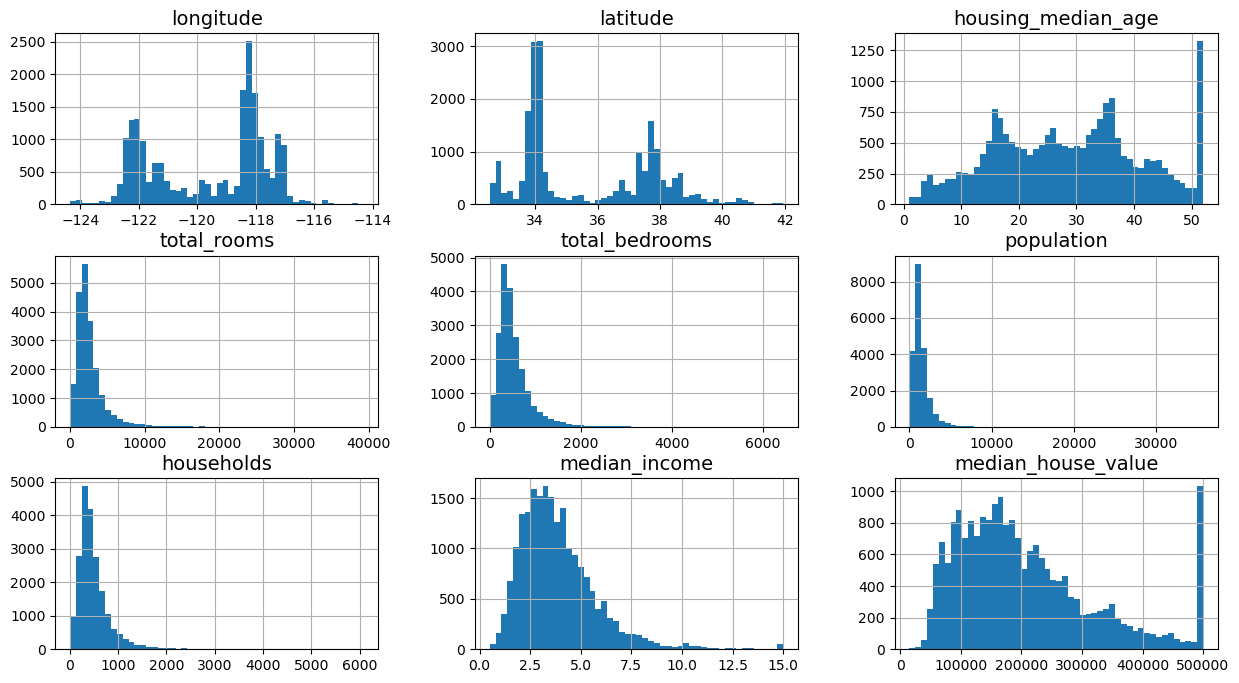

In [7]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(15, 8))
plt.show()

The plots above confirm that:

- Our data has different scales (e.g., `median_income` vs `households`);
- Some attributes are unimodal (e.g., `median_income`); others are multi-modal or resemble a uniform distribution;
- We have some outliers in our data.

Now, we can process the median_income into categories, creating five categories:

- **1:** [0, 1.5[
- **2:** [1.5, 3.0[
- **3:** [3.0, 4.5[
- **4:** [4.5, 6.0[
- **5:** [6.0, inf[

In [8]:
housing["income_category"] = pd.cut(
    housing["median_income"],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)

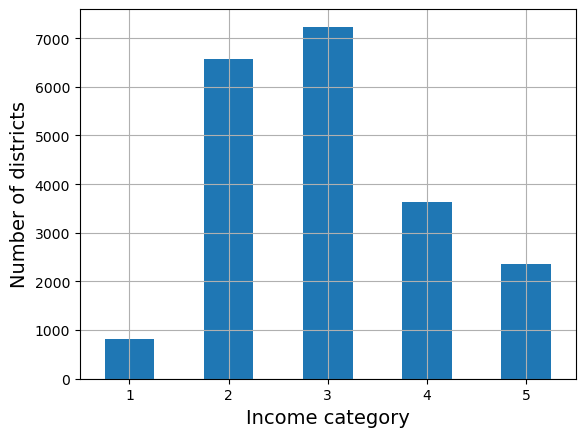

In [9]:
housing["income_category"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

Now, we can explore and visualize the Geographical Data:

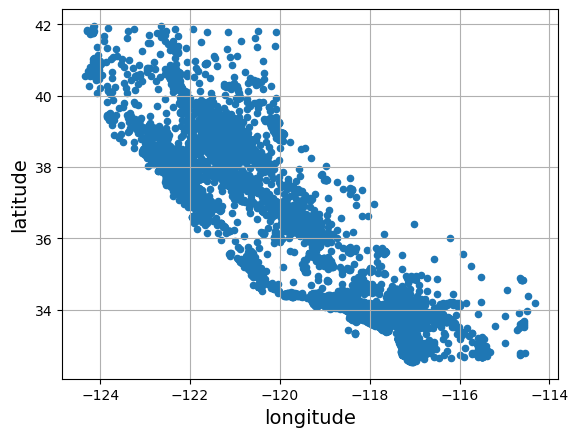

In [10]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

We can also set the alpha to better visualize where data are more crowded.

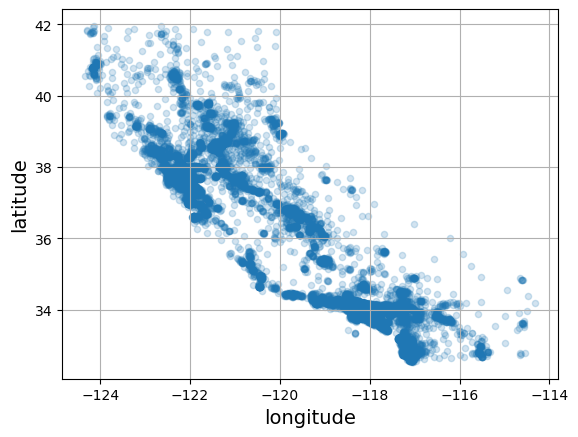

In [11]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

Coding additional information to the scatter plot is possible using colors and bubble size. Take, for instance, the plots below, encoding population and median house value:

> [TODO] Try modifying the attributions (tip: s stands for size, and c stands for color).

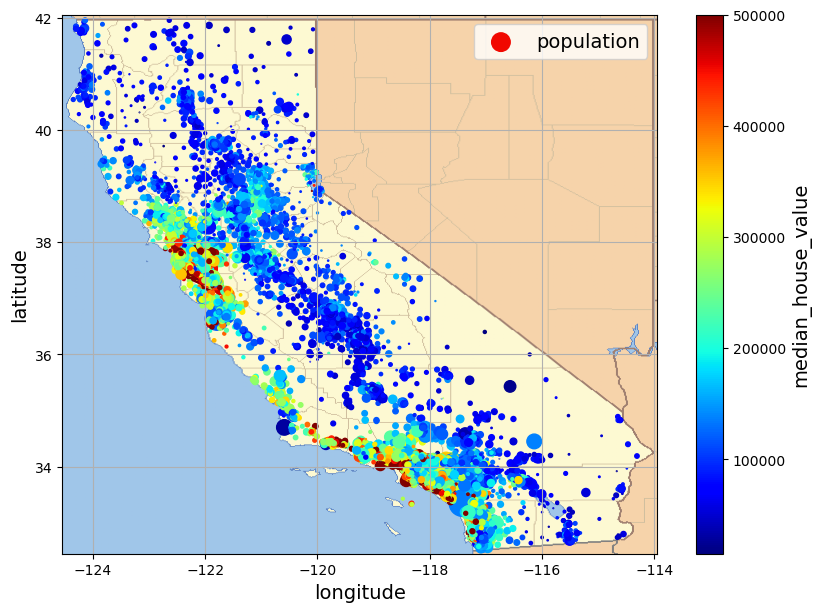

In [12]:
housing.plot(
    kind="scatter", x="longitude", y="latitude", grid=True,
    s=housing["population"] / 100, label="population",
    c="median_house_value", cmap="jet", colorbar=True,
    legend=True, sharex=False, figsize=(10, 7)
)

# Lines below just add the California image in the background
filename = Path("california.png")
if not (filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + str(filename)
    print("Downloading", filename)
    urllib.request.urlretrieve(url, filename)
california_img = plt.imread(filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

plt.show()

Now, we must prepare the text/categorical attribute `ocean_proximity`. We have some options to convert it to numerical data:

- Ordinal
- One-hot encoding

In [13]:
from sklearn.preprocessing import OrdinalEncoder

In [14]:
housing_category = housing[["ocean_proximity"]]

In [15]:
np.unique(housing_category)

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

In [16]:
ordinal_encoder = OrdinalEncoder()
housing_category_ordinal = ordinal_encoder.fit_transform(housing_category)
print(f"The ordinal encoder has the following categories {ordinal_encoder.categories_}\n\n")
print(housing["ocean_proximity"][:5])
print(housing_category_ordinal[:5])
print(housing["ocean_proximity"][-5:])
print(housing_category_ordinal[-5:])

The ordinal encoder has the following categories [array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


0    NEAR BAY
1    NEAR BAY
2    NEAR BAY
3    NEAR BAY
4    NEAR BAY
Name: ocean_proximity, dtype: object
[[3.]
 [3.]
 [3.]
 [3.]
 [3.]]
20635    INLAND
20636    INLAND
20637    INLAND
20638    INLAND
20639    INLAND
Name: ocean_proximity, dtype: object
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [17]:
from sklearn.preprocessing import OneHotEncoder

In [18]:
one_hot_encoder = OneHotEncoder()
housing_category_one_hot = one_hot_encoder.fit_transform(housing_category)
print(f"The ordinal encoder has the following categories {one_hot_encoder.categories_}\n\n")
print(housing["ocean_proximity"][:5])
print(housing_category_one_hot[:5].toarray())
print(housing["ocean_proximity"][-5:])
print(housing_category_one_hot[-5:].toarray())

The ordinal encoder has the following categories [array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


0    NEAR BAY
1    NEAR BAY
2    NEAR BAY
3    NEAR BAY
4    NEAR BAY
Name: ocean_proximity, dtype: object
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]
20635    INLAND
20636    INLAND
20637    INLAND
20638    INLAND
20639    INLAND
Name: ocean_proximity, dtype: object
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


Let's add the one-hot encoded data back to our dataset and also drop the old column:

In [19]:
one_hot_df = pd.DataFrame(
    housing_category_one_hot.toarray(), 
    columns=[category for category in one_hot_encoder.categories_[0]],
    index=housing.index  # Ensure index alignment
)
housing_with_encoded_category = pd.concat([housing, one_hot_df], axis=1)
housing_with_encoded_category.drop('ocean_proximity', axis=1, inplace=True)

Also, we must deal with the missing data. As we have plenty of data, we will remove those missing data (`np.nan`, Not a Number). Here, we will remove rows where np.nan occurs for at least one column.

In [20]:
housing_with_encoded_category

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_category,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,5,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,5,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,5,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,4,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,2,0.0,1.0,0.0,0.0,0.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,2,0.0,1.0,0.0,0.0,0.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,2,0.0,1.0,0.0,0.0,0.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,2,0.0,1.0,0.0,0.0,0.0


In [21]:
housing_with_encoded_category.dropna(inplace=True)

Now, our dataset has 20433 rows. 

We can now look for correlations between our columns (remember that our target variable is the `median_house_value`).

In [22]:
import seaborn as sns

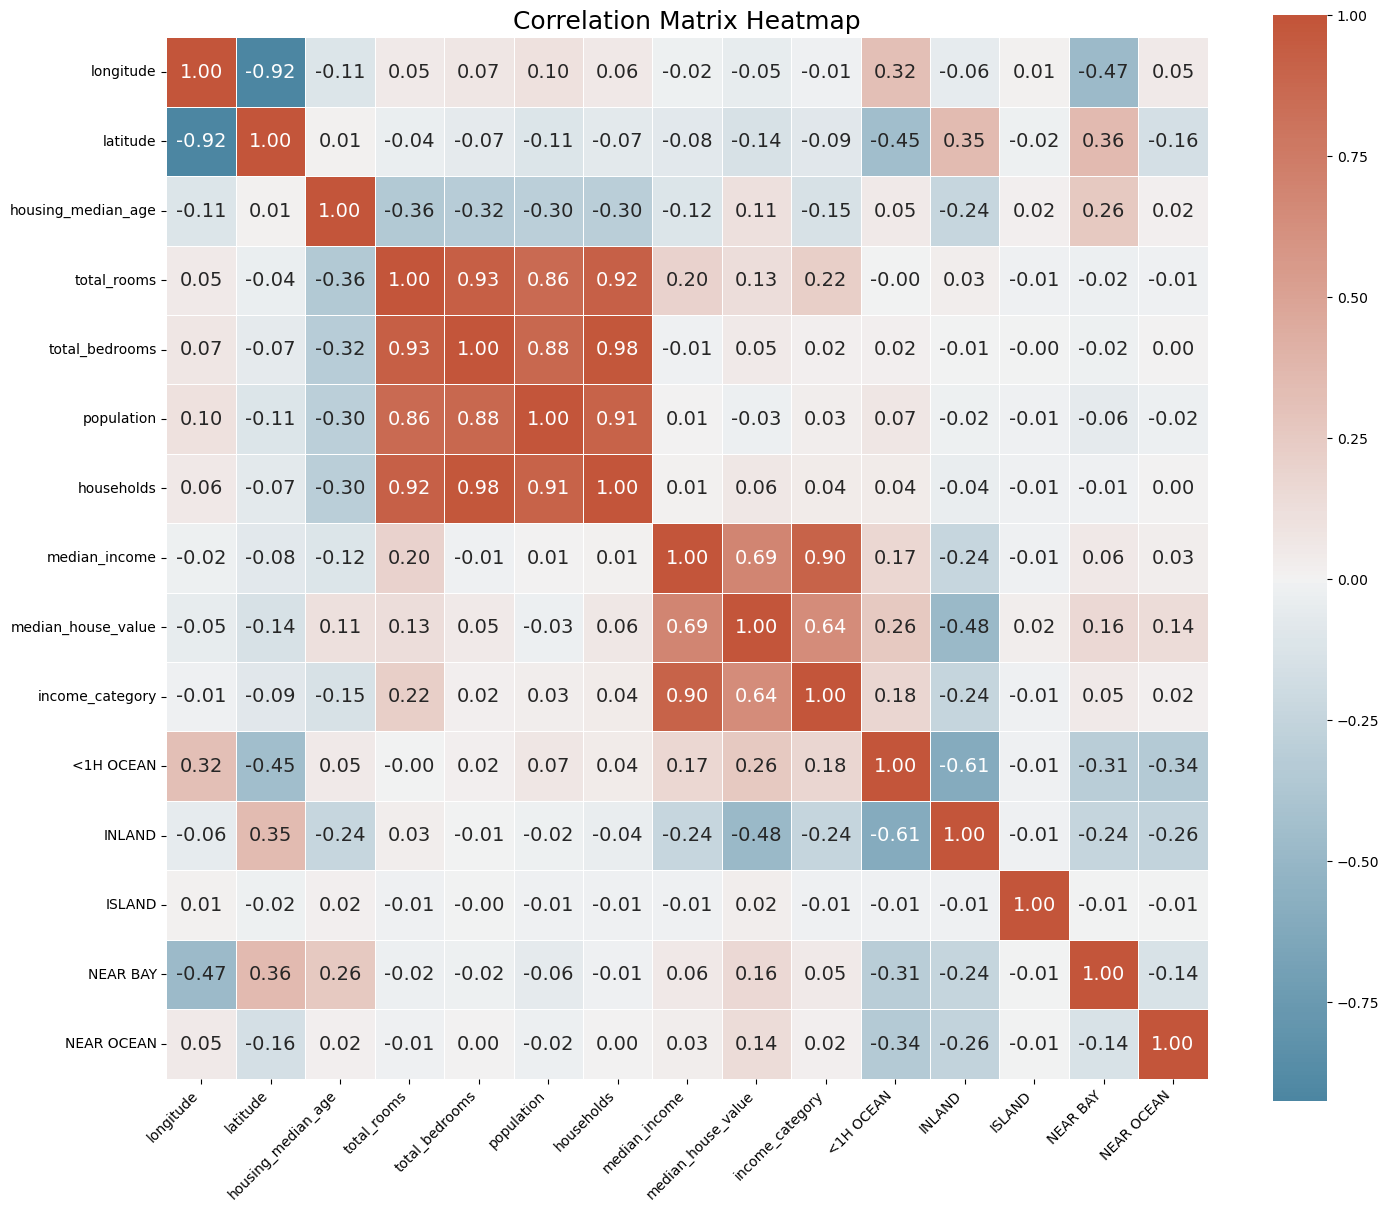

In [23]:
correlation_matrix = housing_with_encoded_category.corr()
plt.figure(figsize=(15, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    correlation_matrix, 
    cmap=cmap,
    center=0,
    square=True,
    linewidths=.5,
    annot=True,
    fmt='.2f',
    cbar_kws={"shrink": .75}
)

plt.title('Correlation Matrix Heatmap', fontsize=18)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust subplot parameters to give specified padding

plt.show()

## 2. Split our data into training and test set, and normalize it

Now, we will split the data into training and testing before learning anything from our data. This is important because we do not want to influence our decisions based on test information. Otherwise, we will also introduce bias into our experiment, which ultimately impedes a correct assessment of generalization to unseen data.

Also, it is important to keep the distribution of data the same, for training and test. In this example, we will stratify our split using the created `income_category`.

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit
# Say about the income category
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing_with_encoded_category, housing_with_encoded_category["income_category"]):
    strat_train_set_n = housing_with_encoded_category.iloc[train_index]
    strat_test_set_n = housing_with_encoded_category.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [25]:
strat_train_set, strat_test_set = strat_splits[0]

Now, we can separate our data into input features (columns) and the target variable.

In [26]:
X_train = strat_train_set.drop("median_house_value", axis=1)
Y_train = strat_train_set["median_house_value"].copy()
X_test = strat_test_set.drop("median_house_value", axis=1)
Y_test = strat_test_set["median_house_value"].copy()

We can also remove some outliers from our data.

In this example, we use the IsolationForest. It computes the anomaly score of each sample using the IsolationForest algorithm.

The IsolationForest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since a tree structure can represent recursive partitioning, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

Outliers will be marked as -1.

In [27]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
train_outlier_pred = isolation_forest.fit_predict(X_train)
test_outlier_pred = isolation_forest.predict(X_test)

In [28]:
print(len(X_train))
print(len(Y_train))
print(len(X_test))
print(len(Y_test))
X_train = X_train.iloc[train_outlier_pred == 1]
Y_train = Y_train.iloc[train_outlier_pred == 1]
X_test = X_test.iloc[test_outlier_pred == 1]
Y_test = Y_test.iloc[test_outlier_pred == 1]
print(len(X_train))
print(len(Y_train))
print(len(X_test))
print(len(Y_test))

16346
16346
4087
4087
12788
12788
3221
3221


> [TODOs]

- Experiment with/without removing outliers.
- Also experiment different algorithms to remove outliers.

Finally, the last step before training our models will be scaling the input data. We will use a StandardScaler (Mean around zero and unit variance), but we invite you to experiment with different scalers.

In [29]:
from sklearn.preprocessing import StandardScaler

In [30]:
std_features_scaler = StandardScaler()
std_target_scaler = StandardScaler()

# Select columns for scaling ----- Scales features (Categories are used "as is")
colums_num = [
    "housing_median_age", "total_rooms", "total_bedrooms",
    "population", "households",	"median_income"
]
colums_cat = [
	"income_category", "<1H OCEAN",	"INLAND", "ISLAND",	"NEAR BAY",	"NEAR OCEAN"
]
X_train_num_scaled = std_features_scaler.fit_transform(X_train[colums_num].values)
X_train_scaled = np.concatenate([X_train_num_scaled, X_train[colums_cat].values], axis=1)
X_test_num_scaled = std_features_scaler.transform(X_test[colums_num].values)
X_test_scaled = np.concatenate([X_test_num_scaled, X_test[colums_cat].values], axis=1)

# Scales target variables
Y_train_scaled = std_target_scaler.fit_transform(Y_train.to_frame())
Y_test_scaled = std_target_scaler.transform(Y_test.to_frame())

## 3. Training the models

Let us start by training a simple Linear Regression model. We will first train the regressor and use it to predict new data. Also, as the target variable is scaled, we need to transform it back to the original range:

In [31]:
from sklearn.linear_model import LinearRegression

In [32]:
X_train_scaled.shape

(12788, 12)

In [33]:
model = LinearRegression()
model.fit(X_train_scaled, Y_train_scaled)

train_preds = model.predict(X_train_scaled)
test_preds = model.predict(X_test_scaled)
train_LR_preds = std_target_scaler.inverse_transform(train_preds)
test_LR_preds = std_target_scaler.inverse_transform(test_preds)

We can also use Pytorch to train a simple "deep" model.

### 1. First, we need to implement the dataset (which will feed input data for the model)

In [34]:
from torch.utils.data import Dataset, DataLoader

In [35]:
class HousingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

### 2. Now, we implement our Deep Learning model.

> It is important to state that such model (i.e., a model with 6 layers) are not considered deep for some authors.

In [36]:
import torch.nn as nn

In [37]:
class HousingModel(nn.Module):
    def __init__(self, input_dim):
        super(HousingModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

### 3. We can define a training function, and use it to train our model.

In [38]:
import torch
from sklearn.metrics import mean_squared_error, r2_score
import torch.optim as optim

In [39]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_loss = running_loss / len(train_loader)
    
    return average_loss

def predict(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            
            y_true.extend(target.cpu().numpy())
            y_pred.extend(output.cpu().numpy())
    
    return np.array(y_true), np.array(y_pred)

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create datasets
train_dataset = HousingDataset(X_train_scaled, Y_train_scaled)
test_dataset = HousingDataset(X_test_scaled, Y_test_scaled)

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

input_dim = X_train_scaled.shape[1]
model = HousingModel(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)

    y_train_true, y_train_pred = predict(model, train_loader, device)

    mse = mean_squared_error(y_train_true, y_train_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_train_true, y_train_pred)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

Epoch 1/100, Loss: 0.3558, RMSE: 0.5533, R²: 0.6939
Epoch 2/100, Loss: 0.3019, RMSE: 0.5646, R²: 0.6813
Epoch 3/100, Loss: 0.2949, RMSE: 0.5303, R²: 0.7188
Epoch 4/100, Loss: 0.2878, RMSE: 0.5207, R²: 0.7289
Epoch 5/100, Loss: 0.2831, RMSE: 0.5245, R²: 0.7249
Epoch 6/100, Loss: 0.2795, RMSE: 0.5434, R²: 0.7047
Epoch 7/100, Loss: 0.2745, RMSE: 0.5340, R²: 0.7148
Epoch 8/100, Loss: 0.2730, RMSE: 0.5192, R²: 0.7305
Epoch 9/100, Loss: 0.2699, RMSE: 0.5226, R²: 0.7269
Epoch 10/100, Loss: 0.2688, RMSE: 0.5098, R²: 0.7401
Epoch 11/100, Loss: 0.2650, RMSE: 0.5053, R²: 0.7447
Epoch 12/100, Loss: 0.2628, RMSE: 0.4957, R²: 0.7542
Epoch 13/100, Loss: 0.2612, RMSE: 0.4977, R²: 0.7523
Epoch 14/100, Loss: 0.2582, RMSE: 0.5037, R²: 0.7463
Epoch 15/100, Loss: 0.2562, RMSE: 0.5051, R²: 0.7449
Epoch 16/100, Loss: 0.2545, RMSE: 0.5063, R²: 0.7436
Epoch 17/100, Loss: 0.2521, RMSE: 0.4952, R²: 0.7547
Epoch 18/100, Loss: 0.2526, RMSE: 0.5034, R²: 0.7466
Epoch 19/100, Loss: 0.2500, RMSE: 0.4934, R²: 0.7566
Ep

Then, we will use the model to predict test data.

In [41]:
_, y_test_pred = predict(model, test_loader, device)
test_DL_preds = std_target_scaler.inverse_transform(y_test_pred)

## 4. Inspecting the outputs

We will create a Data Frame with the target variable (ground truth) and our predictions, using linear Regression and Deep Learning. We will also show some metrics.

In [42]:
test_preds_df = pd.DataFrame(
    np.concatenate([test_LR_preds, Y_test.to_frame(), test_DL_preds], axis=1),
    columns=['Linear Regression', 'Ground Truth', 'Deep Learning']
)

In [43]:
test_preds_df

,Linear Regression,Ground Truth,Deep Learning
0,351102.667499,296600.0,328738.718750
1,242228.870170,199000.0,168319.296875
2,248317.006689,271500.0,150149.562500
3,223916.890031,255900.0,201523.390625
4,182031.095320,151100.0,158140.421875
...,...,...,...
3216,101658.113020,165000.0,125088.710938
3217,211053.244753,252600.0,236720.453125
3218,222650.570020,277300.0,187212.156250
3219,271483.390543,223500.0,252538.015625


In [44]:
lr_mse = mean_squared_error(test_preds_df['Ground Truth'], test_preds_df['Linear Regression'])
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(test_preds_df['Ground Truth'], test_preds_df['Linear Regression'])
print("Linear Regression Metrics")
print(f"MSE: {lr_mse}")
print(f"RMSE: {lr_rmse}")
print(f"R2: {lr_r2}")

dl_mse = mean_squared_error(test_preds_df['Ground Truth'], test_preds_df['Deep Learning'])
dl_rmse = np.sqrt(dl_mse)
dl_r2 = r2_score(test_preds_df['Ground Truth'], test_preds_df['Deep Learning'])
print("\nDeep Learning Metrics")
print(f"MSE: {dl_mse}")
print(f"RMSE: {dl_rmse}")
print(f"R2: {dl_r2}")

Linear Regression Metrics
MSE: 4139281638.2354617
RMSE: 64337.24922807519
R2: 0.6229621834937301

Deep Learning Metrics
MSE: 3789294078.933276
RMSE: 61557.24229473959
R2: 0.6548417598783676


# Extra acitivites

- Why R2 is better on training than on test?
- Could you improve results? Maybe selecting features with more correlaction?